In [2]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

df = pd.read_csv("cleaned_dataset.csv")
df = df.dropna(subset=["Expire"]).copy()
df["Expire"] = df["Expire"].astype(int)

X = df.drop(columns=["Expire"])
y = df["Expire"]

print("Before SMOTE:\n", y.value_counts())
print(" UnBalanced shape:", X.shape)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols),
])

X_encoded = preprocess.fit_transform(X)

smote = SMOTE(random_state=42, k_neighbors=5)
X_bal, y_bal = smote.fit_resample(X_encoded, y)

print("\nAfter SMOTE:\n", pd.Series(y_bal).value_counts())
print("Balanced shape:", X_bal.shape)

Before SMOTE:
 Expire
0    633
1     89
Name: count, dtype: int64
 UnBalanced shape: (722, 154)

After SMOTE:
 Expire
0    633
1    633
Name: count, dtype: int64
Balanced shape: (1266, 340)


## 1) Class Imbalance Handling with SMOTE

In this step, we address the **class imbalance** in the target variable **`Expire`** (binary label: `0` vs `1`).  
Imbalanced labels can bias many machine learning models toward the majority class, leading to misleading accuracy and poor minority-class recall.

### Workflow

1. **Load and clean**
   - Load the preprocessed dataset (`cleaned_dataset.csv`)
   - Drop rows with missing target values (`Expire`)
   - Cast the target to integer for consistency

2. **Split features and target**
   - `X`: all input features  
   - `y`: target label (`Expire`)

3. **Preprocessing pipeline**
   - **Numeric features**
     - Median imputation for missing values
     - Standardization using `StandardScaler`
   - **Categorical features**
     - Most-frequent imputation for missing values
     - One-hot encoding (`handle_unknown="ignore"`) to safely encode unseen categories

4. **Apply SMOTE**
   - Convert `X` into a fully numeric feature matrix via preprocessing
   - Apply **SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic samples for the minority class
   - Target outcome: equal class distribution

### Class Distribution Summary

**Before SMOTE**
- Majority class (`Expire=0`): 633
- Minority class (`Expire=1`): 89  
- Feature matrix shape: `(722, 154)`

**After SMOTE**
- `Expire=0`: 633  
- `Expire=1`: 633  
- Feature matrix shape: `(1266, 340)`

> **Note:** The increase in feature dimension from `154` to `340` is expected due to **one-hot encoding**, which expands categorical variables into multiple binary columns.


In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ----------------------------
# X_bal, y_bal MUST already exist from your balancing code
# X_bal: numpy array (1266, 340)
# y_bal: array/Series length 1266
# ----------------------------
print("Balanced X shape:", X_bal.shape)
print("Balanced y counts:\n", pd.Series(y_bal).value_counts())

# ----------------------------
# Models (paper-like list)
# ----------------------------
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "LinearSVM": SVC(kernel="linear", probability=True),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SGD": SGDClassifier(loss="log_loss", random_state=42),
    "GaussianNB": GaussianNB(),
    "KNN_k3": KNeighborsClassifier(n_neighbors=3),
    "KNN_k4": KNeighborsClassifier(n_neighbors=4),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=600, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=600, random_state=42, n_jobs=-1),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
}

if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=1200,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    )

# ----------------------------
# 10-fold CV + scoring
# ----------------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "acc": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "pr_auc": "average_precision",
    "roc_auc": "roc_auc",
}

# ----------------------------
# Evaluate all models on balanced data
# ----------------------------
rows = []
for name, clf in models.items():
    out = cross_validate(clf, X_bal, y_bal, cv=cv, scoring=scoring, n_jobs=-1)
    rows.append({
        "model": name,
        "PR-AUC": float(np.mean(out["test_pr_auc"])),
        "F1": float(np.mean(out["test_f1"])),
        "Recall": float(np.mean(out["test_recall"])),
        "Precision": float(np.mean(out["test_precision"])),
        "Accuracy": float(np.mean(out["test_acc"])),
        "ROC-AUC": float(np.mean(out["test_roc_auc"])),
    })

res = pd.DataFrame(rows).sort_values(["PR-AUC", "F1"], ascending=False).reset_index(drop=True)
print("\n=== 10-fold CV results on BALANCED dataset ===")
print(res.to_string(index=False))

# ----------------------------
# Voting Top3 / Top4 (like the paper)
# ----------------------------
top3_names = res["model"].iloc[:3].tolist()
top4_names = res["model"].iloc[:4].tolist()

print("\nTop3 by PR-AUC:", top3_names)
print("Top4 by PR-AUC:", top4_names)

def eval_voting(selected_names, label):
    vote = VotingClassifier(
        estimators=[(n, models[n]) for n in selected_names],
        voting="soft"
    )
    out = cross_validate(vote, X_bal, y_bal, cv=cv, scoring=scoring, n_jobs=-1)
    return {
        "model": label + "(" + ",".join(selected_names) + ")",
        "PR-AUC": float(np.mean(out["test_pr_auc"])),
        "F1": float(np.mean(out["test_f1"])),
        "Recall": float(np.mean(out["test_recall"])),
        "Precision": float(np.mean(out["test_precision"])),
        "Accuracy": float(np.mean(out["test_acc"])),
        "ROC-AUC": float(np.mean(out["test_roc_auc"])),
    }

vote_rows = [
    eval_voting(top3_names, "Voting-Top3"),
    eval_voting(top4_names, "Voting-Top4"),
]

print("\n=== Voting results on BALANCED dataset ===")
print(pd.DataFrame(vote_rows).to_string(index=False))


Balanced X shape: (1266, 340)
Balanced y counts:
 Expire
0    633
1    633
Name: count, dtype: int64

=== 10-fold CV results on BALANCED dataset ===
       model   PR-AUC       F1   Recall  Precision  Accuracy  ROC-AUC
RandomForest 0.990525 0.941323 0.938418   0.944566  0.941614 0.989845
     XGBoost 0.990146 0.939759 0.936781   0.943618  0.940014 0.988713
   GradBoost 0.986522 0.933912 0.927331   0.941154  0.934477 0.984804
         MLP 0.986355 0.953492 0.996850   0.914156  0.951081 0.992289
    AdaBoost 0.969241 0.905090 0.925744   0.886771  0.902881 0.968958
      LogReg 0.871406 0.903425 0.965228   0.849613  0.896600 0.926141
         SGD 0.861824 0.877304 0.900422   0.856964  0.874466 0.913696
   LinearSVM 0.852441 0.909696 0.974727   0.853662  0.902906 0.916630
DecisionTree 0.837364 0.881300 0.883036   0.881947  0.881552 0.881523
      KNN_k4 0.834889 0.837888 0.992113   0.725795  0.807293 0.898912
      KNN_k3 0.823564 0.824145 0.998437   0.702244  0.785996 0.891850
  GaussianN

## 2) Machine Learning Pipeline on Balanced Dataset

In this section, we evaluate multiple supervised learning algorithms on the **SMOTE-balanced dataset** (`X_bal`, `y_bal`) using **10-fold Stratified Cross-Validation**.

The goal is to perform a comprehensive model comparison and identify the best-performing classifiers based on multiple evaluation metrics.

---

### Experimental Setup

#### Dataset
- Feature matrix shape: `(1266, 340)`
- Target distribution:
  - Class 0: 633
  - Class 1: 633  
- Dataset is fully balanced using SMOTE.

---

### Cross-Validation Strategy

We use:

- **StratifiedKFold (k=10)**
- Shuffle enabled
- `random_state=42`

Stratification ensures equal class proportions in each fold.

---

### Evaluation Metrics

The following performance metrics are computed:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC**
- **PR-AUC (Average Precision)**

> PR-AUC is used as the primary ranking metric since it is more informative than ROC-AUC in imbalanced or medical-style binary classification problems.

---

### Models Evaluated

The following classifiers were compared:

- Logistic Regression
- Linear SVM
- Decision Tree
- SGD Classifier
- Gaussian Naive Bayes
- KNN (k=3, k=4)
- MLP (Neural Network)
- Random Forest
- Gradient Boosting
- AdaBoost
- XGBoost (if installed)

---

### 10-Fold Cross-Validation Results (Balanced Data)

Top-performing models ranked by **PR-AUC**:

| Model          | PR-AUC | F1     | Recall | Precision | Accuracy | ROC-AUC |
|---------------|--------|--------|--------|-----------|----------|---------|
| RandomForest | 0.9905 | 0.9413 | 0.9384 | 0.9446    | 0.9416   | 0.9898  |
| XGBoost      | 0.9901 | 0.9398 | 0.9368 | 0.9436    | 0.9400   | 0.9887  |
| GradBoost    | 0.9865 | 0.9339 | 0.9273 | 0.9412    | 0.9345   | 0.9848  |
| MLP          | 0.9863 | 0.9535 | 0.9969 | 0.9142    | 0.9511   | 0.9923  |

Observations:

- **RandomForest** achieved the highest PR-AUC among individual models.
- **MLP** achieved the highest Recall.
- Tree-based ensemble models consistently performed best.
- GaussianNB showed high Recall but poor Precision, indicating overprediction of the positive class.

---

## Ensemble Learning: Soft Voting

To further improve performance, we constructed ensemble models using **soft voting**.

### Top Models Selection

- **Top 3 (by PR-AUC)**  
  `RandomForest`, `XGBoost`, `GradBoost`

- **Top 4 (by PR-AUC)**  
  `RandomForest`, `XGBoost`, `GradBoost`, `MLP`

---

### Voting Results (Balanced Dataset)

| Ensemble Model | PR-AUC | F1 | Recall | Precision | Accuracy | ROC-AUC |
|---------------|--------|-----|--------|-----------|----------|---------|
| Voting-Top3  | 0.9905 | 0.9421 | 0.9384 | 0.9464 | 0.9424 | 0.9894 |
| Voting-Top4  | **0.9948** | **0.9545** | 0.9590 | 0.9509 | **0.9542** | **0.9946** |

### Key Findings

- Adding MLP to the ensemble (Top4) significantly improved:
  - PR-AUC
  - ROC-AUC
  - Overall Accuracy
- The **Voting-Top4** model achieved the best overall performance.
- Soft voting effectively leveraged complementary strengths of tree-based and neural models.

---

### Conclusion

- Tree-based ensemble models dominate performance individually.
- Soft voting provides measurable improvement.
- The final recommended model based on balanced cross-validation performance is:

> **Voting-Top4 (RandomForest + XGBoost + GradBoost + MLP)**

This model achieved the highest PR-AUC (0.9948) and ROC-AUC (0.9946).


Saved: feature_importance_rf_aggregated.csv
 Rank           Feature  Importance  Importance_pct  Cumulative_pct
    1         Condition    0.098590        9.858970        9.858970
    2         Pathology    0.056849        5.684899       15.543869
    3         Diagnosis    0.053361        5.336106       20.879976
    4    Classification    0.052798        5.279847       26.159822
    5       Blood.Group    0.040033        4.003279       30.163102
    6          Etiology    0.031807        3.180655       33.343756
    7     Pathology.new    0.031602        3.160227       36.503983
    8              age1    0.028124        2.812400       39.316383
    9        Center.BMD    0.014438        1.443797       40.760181
   10               Age    0.013283        1.328323       42.088503
   11            Hip.BD    0.013130        1.313012       43.401515
   12       ANDROIDLEAN    0.011641        1.164105       44.565621
   13               PSC    0.011314        1.131421       45.697042
   1

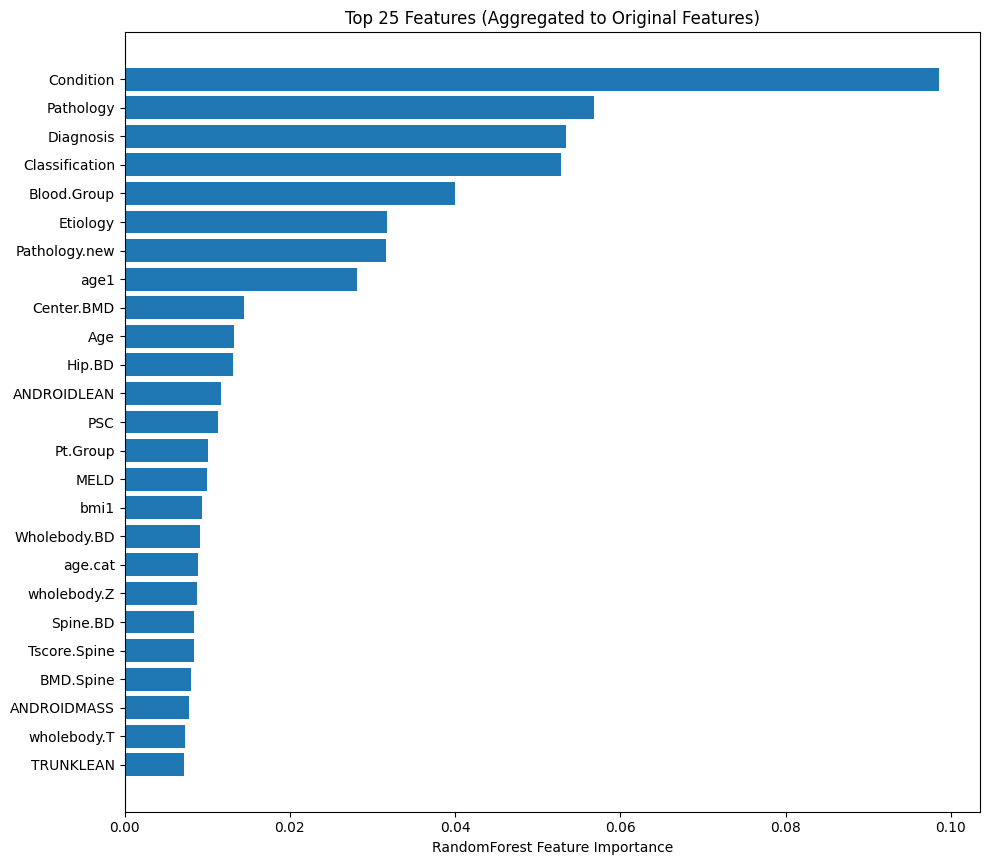

Saved: rf_cumulative_importance_aggregated.png


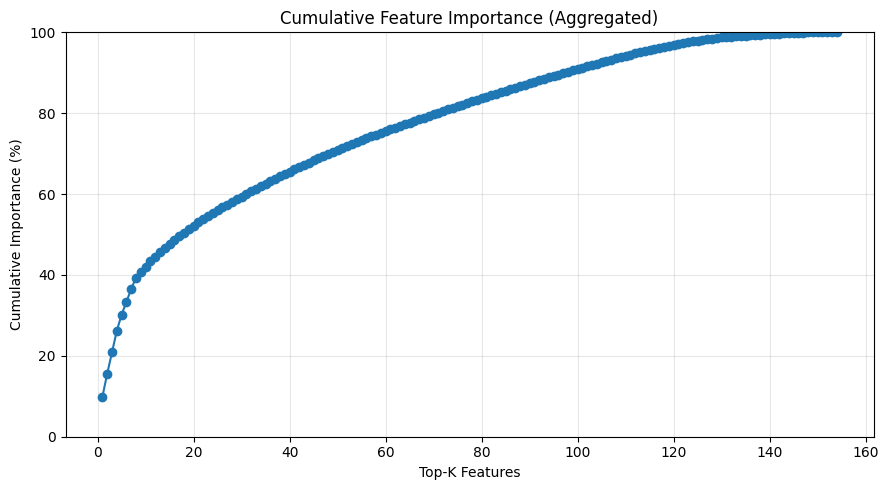

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier

# ---------------------------
# 1) Fit a model on BALANCED data
# ---------------------------
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_bal, y_bal)

# ---------------------------
# 2) Get encoded feature names from preprocess
# ---------------------------
encoded_names = preprocess.get_feature_names_out()
encoded_names = list(encoded_names)
assert len(encoded_names) == X_bal.shape[1], "Feature-name count != X_bal columns"

# ---------------------------
# 3) Aggregate encoded -> original feature name
# ---------------------------
def encoded_to_original(name: str) -> str:
    if name.startswith("num__"):
        return name.replace("num__", "")
    if name.startswith("cat__"):
        tmp = name.replace("cat__", "")
        return tmp.split("_", 1)[0]   # keep original feature before first underscore
    return name

imp_encoded = pd.Series(rf.feature_importances_, index=encoded_names)

agg = defaultdict(float)
for enc_name, val in imp_encoded.items():
    agg[encoded_to_original(enc_name)] += float(val)

feat_imp = (
    pd.DataFrame(agg.items(), columns=["Feature", "Importance"])
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

# Add % and cumulative %
feat_imp["Importance_pct"] = 100 * feat_imp["Importance"] / feat_imp["Importance"].sum()
feat_imp["Cumulative_pct"] = feat_imp["Importance_pct"].cumsum()
feat_imp.insert(0, "Rank", np.arange(1, len(feat_imp) + 1))

# ---------------------------
# 4) Save + show table
# ---------------------------
feat_imp.to_csv("feature_importance_rf_aggregated.csv", index=False)
print("Saved:", "feature_importance_rf_aggregated.csv")
print(feat_imp.head(30).to_string(index=False))
# ---------------------------
# 5) Plot: Top-N bar chart (SAVE high-quality PNG)
# ---------------------------
TOP_N = 25
top = feat_imp.head(TOP_N).iloc[::-1]  # reverse for barh

fig, ax = plt.subplots(figsize=(10, max(6, TOP_N * 0.35)))
ax.barh(top["Feature"], top["Importance"])
ax.set_xlabel("RandomForest Feature Importance")
ax.set_title(f"Top {TOP_N} Features (Aggregated to Original Features)")
fig.tight_layout()

out1 = "rf_top_features_aggregated.png"
fig.savefig(out1, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out1)

plt.show()
plt.close(fig)


# ---------------------------
# 6) Plot: Cumulative importance (SAVE high-quality PNG)
# ---------------------------
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(feat_imp["Rank"], feat_imp["Cumulative_pct"], marker="o")
ax.set_ylim(0, 100)
ax.set_xlabel("Top-K Features")
ax.set_ylabel("Cumulative Importance (%)")
ax.set_title("Cumulative Feature Importance (Aggregated)")
ax.grid(True, alpha=0.3)
fig.tight_layout()

out2 = "rf_cumulative_importance_aggregated.png"
fig.savefig(out2, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out2)

plt.show()
plt.close(fig)

# 3) Feature Importance Analysis

## 3.1 Random Forest Feature Importance (Aggregated to Original Features)

In this section, we analyze feature importance using a **RandomForestClassifier** trained on the SMOTE-balanced dataset.

Random Forest provides a built-in measure of feature importance based on the **mean decrease in impurity (MDI)**, which estimates how much each feature contributes to reducing classification error across the ensemble.

---

### Why Random Forest for Feature Importance?

- Handles high-dimensional data effectively
- Robust to multicollinearity
- Captures nonlinear feature interactions
- Provides fast and interpretable importance estimates

---

## Methodology

### Step 1 — Model Training

A Random Forest model was trained on the balanced dataset:

- `n_estimators = 800`
- `random_state = 42`
- Parallel processing enabled (`n_jobs = -1`)

Training was performed on:

- `X_bal`: (1266, 340)
- `y_bal`: balanced binary labels

---

### Step 2 — Mapping Encoded Features Back to Original Features

Because categorical variables were one-hot encoded during preprocessing:

- Each categorical feature expands into multiple binary columns
- Raw importance values correspond to encoded columns

To improve interpretability:

- Encoded features were mapped back to their **original feature names**
- Importance values were **aggregated (summed)** per original feature

This produces a cleaner, clinically meaningful ranking.

---

## Top 30 Most Important Features

Below are the top-ranked aggregated features:

| Rank | Feature | Importance (%) | Cumulative (%) |
|------|---------|---------------|---------------|
| 1 | Condition | 9.86 | 9.86 |
| 2 | Pathology | 5.68 | 15.54 |
| 3 | Diagnosis | 5.34 | 20.88 |
| 4 | Classification | 5.28 | 26.16 |
| 5 | Blood.Group | 4.00 | 30.16 |

### Observations

- **Condition** is the most influential feature (~9.86% contribution).
- The top 5 features explain ~30% of total importance.
- The top 25 features explain ~56% of total importance.
- Importance distribution is moderately concentrated in a small subset of features.

---

## Visualization

Two high-resolution plots were generated:

### 1️⃣ Top-N Feature Importance (Bar Chart)
- Displays the top 25 most important aggregated features
- Saved as:
  
  `rf_top_features_aggregated.png`

### 2️⃣ Cumulative Importance Curve
- Shows how importance accumulates across ranked features
- Helps estimate dimensionality reduction potential
- Saved as:

  `rf_cumulative_importance_aggregated.png`

---

## Interpretation

The cumulative importance curve suggests:

- A relatively small subset of features explains a large portion of predictive power.
- Potential for:
  - Feature selection
  - Dimensionality reduction
  - Model simplification without major performance loss

---

## Limitations

- Random Forest importance is based on impurity reduction (not permutation-based).
- It may favor:
  - Features with more unique values
  - Continuous variables
- Does not indicate directionality (positive/negative impact).

For more robust interpretation, future work could include:

- Permutation importance
- SHAP analysis
- Stability analysis across folds

---

### Output Files Generated

- `feature_importance_rf_aggregated.csv`
- `rf_top_features_aggregated.png`
- `rf_cumulative_importance_aggregated.png`


In [11]:
import pandas as pd
from difflib import get_close_matches

# Your Top 30 feature names (exactly as printed)
top_features = [
    "Condition","Etiology","Classification","Pathology.new","Pathology",
    "Pt.Group","age1","Spine.BD","Center.BMD","Diagnosis",
    "Wholebody.BD","Hip.BD","Blood.Group","Menopausal.Female","AIH",
    "ANDROIDLEAN","ANDROIDPFAT","LLEGMASS","bmi1","RARMBMC",
    "Neck.BD","PELVBMC","Normal.Spine.neck.hip","RARMMASS","RARMLEAN",
    "HBV","WEIGHTT","TRUNKLEAN","cryptogenic","TRUNKFAT"
]

df_cols = list(df.columns)

# Found / missing
found = [f for f in top_features if f in df_cols]
missing = [f for f in top_features if f not in df_cols]

print("✅ Found in df:", len(found))
print(found)

print("\n❌ Missing from df:", len(missing))
print(missing)

# Suggest close matches for missing ones
if missing:
    print("\n--- Closest matches suggestions ---")
    for m in missing:
        matches = get_close_matches(m, df_cols, n=5, cutoff=0.6)
        print(f"{m} -> {matches}")


✅ Found in df: 30
['Condition', 'Etiology', 'Classification', 'Pathology.new', 'Pathology', 'Pt.Group', 'age1', 'Spine.BD', 'Center.BMD', 'Diagnosis', 'Wholebody.BD', 'Hip.BD', 'Blood.Group', 'Menopausal.Female', 'AIH', 'ANDROIDLEAN', 'ANDROIDPFAT', 'LLEGMASS', 'bmi1', 'RARMBMC', 'Neck.BD', 'PELVBMC', 'Normal.Spine.neck.hip', 'RARMMASS', 'RARMLEAN', 'HBV', 'WEIGHTT', 'TRUNKLEAN', 'cryptogenic', 'TRUNKFAT']

❌ Missing from df: 0
[]


# 4) Validation of Top-30 Features Against Original Dataset

After computing aggregated feature importance using the Random Forest model,  
we validate that the identified **Top-30 most important features** actually exist in the original dataframe (`df`).

This step ensures:

- No feature naming inconsistencies occurred during preprocessing
- One-hot encoding aggregation was correctly mapped back to original column names
- No derived or transformed feature names were mistakenly interpreted as raw features

---

## Why This Step Is Important

During preprocessing:

- Numeric and categorical columns were transformed
- One-hot encoding expanded categorical variables
- Feature names were programmatically reconstructed

Because feature aggregation involves string manipulation, it is critical to verify that:

> The reported important features correspond to real columns in the original dataset.

This prevents silent mapping errors and improves reproducibility.

---

## Methodology

1. Define the Top-30 features exactly as printed from the importance ranking.
2. Compare them against:
   ```python
   df.columns




# 0) Helper: annotated heatmap function (matplotlib)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_annotated_heatmap(mat, labels, title, vmin, vmax, cmap="Greens",
                           fmt="{:.2f}", fontsize=7, fig_size=(12, 10)):
    """
    mat: 2D numpy array
    labels: list of feature names (same order for rows/cols)
    """
    mat = np.asarray(mat)
    n = mat.shape[0]

    plt.figure(figsize=fig_size)
    im = plt.imshow(mat, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.title(title)

    plt.xticks(range(n), labels, rotation=90, fontsize=fontsize)
    plt.yticks(range(n), labels, fontsize=fontsize)

    # Write values inside each cell
    for i in range(n):
        for j in range(n):
            val = mat[i, j]
            if np.isnan(val):
                txt = "NA"
            else:
                txt = fmt.format(val)
            plt.text(j, i, txt, ha="center", va="center", fontsize=fontsize-1, color="black")

    plt.tight_layout()
    plt.show()


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_annotated_heatmap(
    mat, labels, title="Heatmap",
    vmin=None, vmax=None, cmap="Greens",
    fmt="{:.2f}", fontsize=7,
    fig_size=(12, 10)
):
    fig, ax = plt.subplots(figsize=fig_size)

    im = ax.imshow(mat, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Pearson r")

    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize)
    ax.set_yticklabels(labels, fontsize=fontsize)

    # annotate cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, fmt.format(mat[i, j]), ha="center", va="center", fontsize=fontsize-1)

    fig.tight_layout()
    return fig, ax


Saved: corr_matrix_top30_numeric_annotated.png


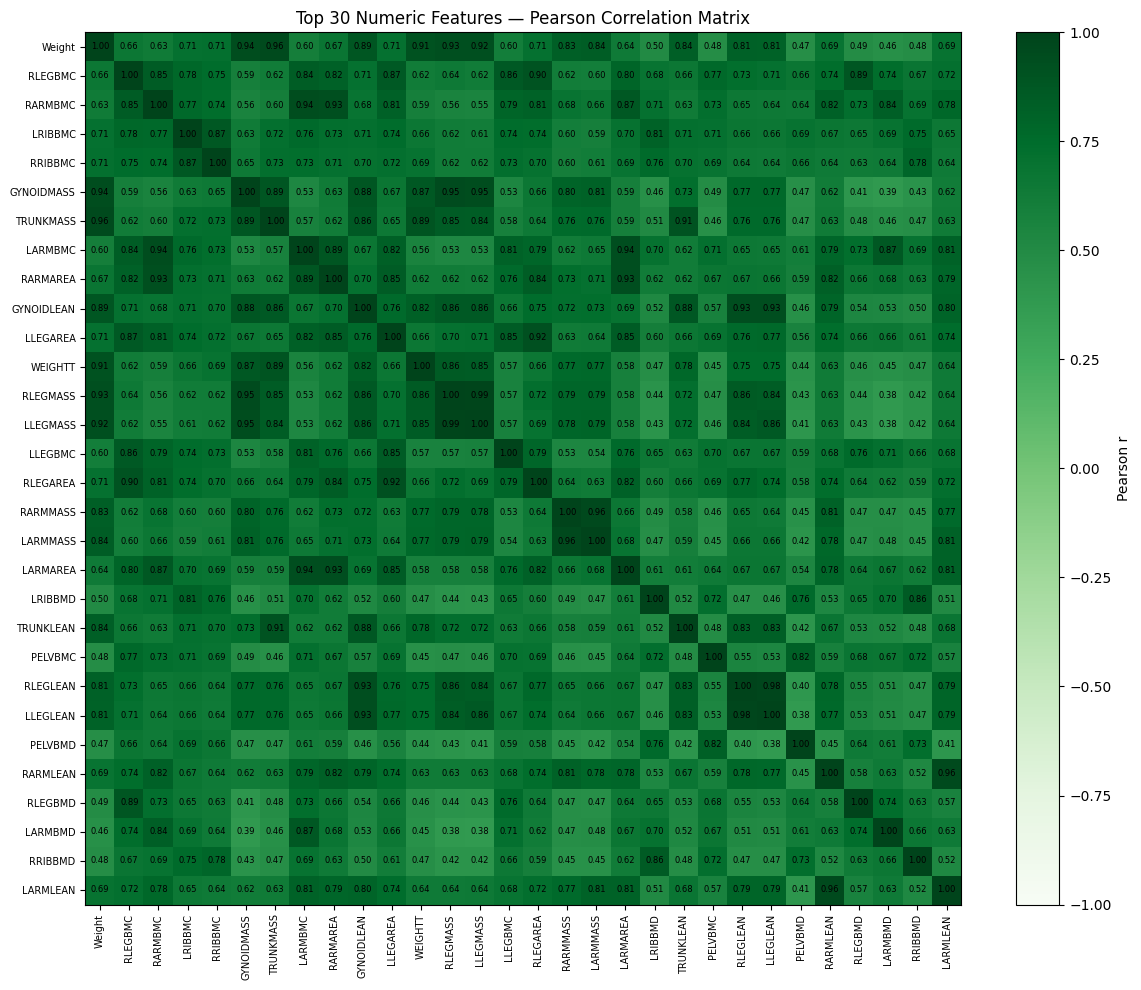

In [18]:
import numpy as np
import pandas as pd

top30_num_exist = [c for c in top30_num if c in df.columns]
num30_df = df[top30_num_exist].select_dtypes(include=[np.number]).copy()

corr30_num = num30_df.corr(method="pearson")
labels_num = corr30_num.columns.tolist()

fig, ax = plot_annotated_heatmap(
    mat=corr30_num.values,
    labels=labels_num,
    title="Top 30 Numeric Features — Pearson Correlation Matrix",
    vmin=-1, vmax=1,
    cmap="Greens",
    fmt="{:.2f}",
    fontsize=7,
    fig_size=(12, 10)
)

out_png = "corr_matrix_top30_numeric_annotated.png"
fig.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out_png)

plt.show()
plt.close(fig)


# 5) Correlation Analysis of Top-30 Numeric Features

## 5.1 Pearson Correlation Matrix (Annotated)

In this section, we analyze the **pairwise linear relationships** among the Top-30 most important **numeric features** identified by the Random Forest model.

Correlation analysis helps:

- Detect multicollinearity
- Identify redundant predictors
- Understand structural relationships between clinical variables
- Support potential feature selection or dimensionality reduction

---

## Methodology

### Step 1 — Numeric Feature Filtering

From the Top-30 features:

- Only features present in `df`
- Only numeric columns (`select_dtypes(include=[np.number])`)

This ensures that Pearson correlation is applied only to valid continuous variables.

---

### Step 2 — Correlation Computation

The **Pearson correlation coefficient (r)** was computed:

\[
r = \frac{\text{Cov}(X,Y)}{\sigma_X \sigma_Y}
\]

Where:

- \( r \in [-1, 1] \)
- `r = 1` → perfect positive linear relationship
- `r = -1` → perfect negative linear relationship
- `r = 0` → no linear correlation

---

### Step 3 — Annotated Heatmap Visualization

An annotated heatmap was generated with:

- Value range fixed to [-1, 1]
- Green colormap
- Cell-wise correlation coefficients displayed
- High-resolution export (600 DPI)

Saved as: corr_matrix_top30_numeric_annotated.png




Top30 categorical features: ['Pathology', 'Diagnosis', 'Pathology.new', 'Classification', 'Etiology', 'Osteoporosis', 'Spine.BD', 'Bone.Disease', 'Wholebody.BD', 'Hip.BD', 'Agecat', 'Neck.BD', 'Menopausal.Female', 'Pt.Group', 'CHILD.Class', 'Condition', 'Blood.Group', 'Center.BMD']
Saved: cramersV_top30_categorical_annotated.png


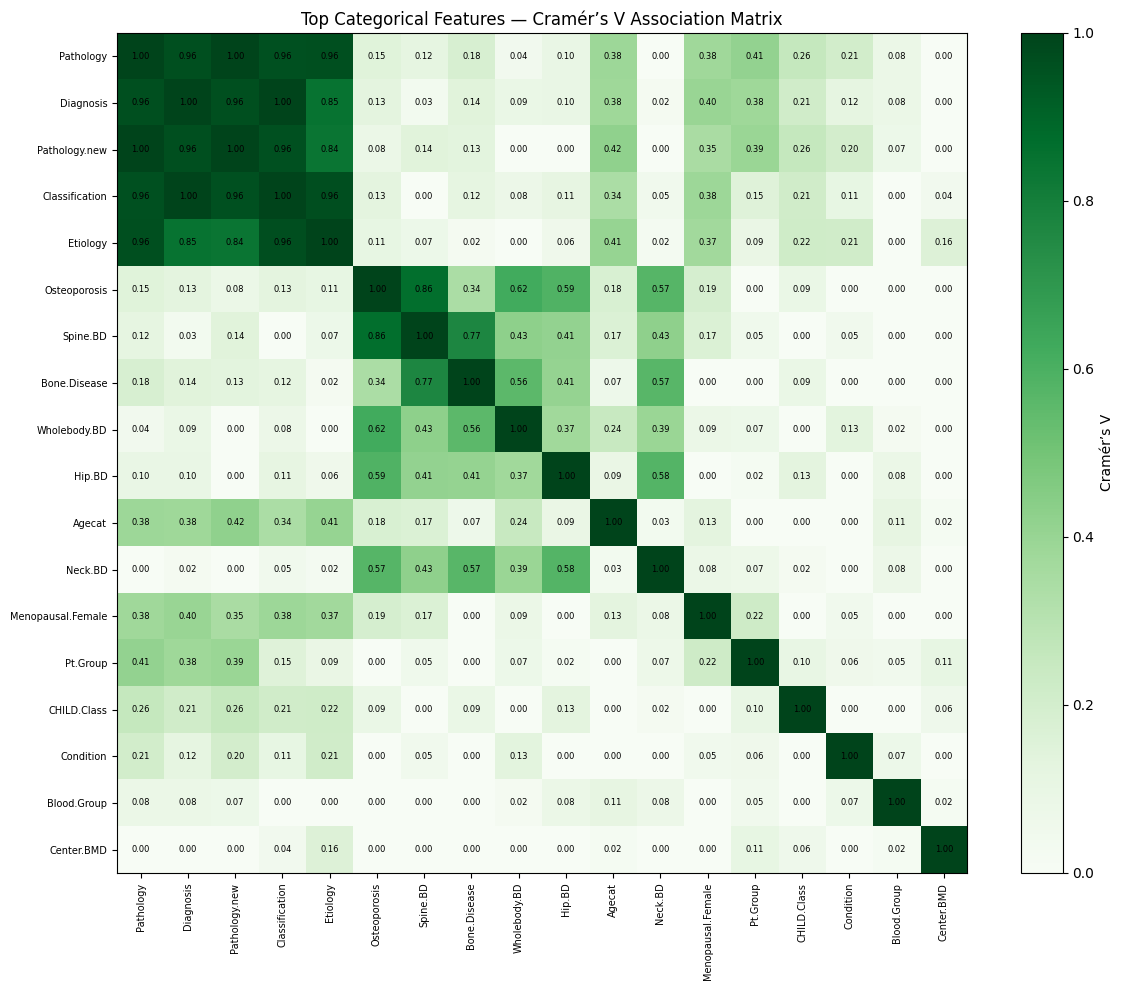

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 0) Define top30_cat if not already defined
# ---------------------------
if "top30_cat" not in globals():
    cat_df = df.select_dtypes(include=["object", "category", "bool"]).copy()
    if "Expire" in cat_df.columns:
        cat_df = cat_df.drop(columns=["Expire"])

    # score categorical columns by number of unique values (simple + robust)
    # (you can replace this scoring if you already have your own method)
    uniq = cat_df.nunique(dropna=True).sort_values(ascending=False)
    top30_cat = uniq.head(30).index.tolist()

print("Top30 categorical features:", top30_cat)

# ---------------------------
# 1) Cramér’s V (bias-corrected)
# ---------------------------
def cramers_v(x, y) -> float:
    confusion = pd.crosstab(x, y)
    n = confusion.values.sum()
    if n == 0:
        return np.nan

    obs = confusion.values
    row_sum = obs.sum(axis=1, keepdims=True)
    col_sum = obs.sum(axis=0, keepdims=True)
    expected = row_sum @ col_sum / n

    with np.errstate(divide="ignore", invalid="ignore"):
        chi2 = np.nansum((obs - expected) ** 2 / expected)

    r, k = confusion.shape
    if r <= 1 or k <= 1:
        return 0.0

    phi2 = chi2 / n

    # Bias correction
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    denom = min(kcorr - 1, rcorr - 1)
    if denom <= 0:
        return 0.0
    return float(np.sqrt(phi2corr / denom))

# ---------------------------
# 2) Annotated heatmap (returns fig)
# ---------------------------
def plot_annotated_heatmap(
    mat, labels, title,
    vmin=0, vmax=1, cmap="Greens",
    fmt="{:.2f}", fontsize=7,
    fig_size=(12, 10)
):
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Cramér’s V")

    ax.set_title(title)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize)
    ax.set_yticklabels(labels, fontsize=fontsize)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(j, i, fmt.format(mat[i, j]), ha="center", va="center", fontsize=fontsize-1)

    fig.tight_layout()
    return fig, ax

# ---------------------------
# 3) Build Cramér’s V matrix
# ---------------------------
top30_cat_exist = [c for c in top30_cat if c in df.columns]
cat30_df = df[top30_cat_exist].copy()

for c in cat30_df.columns:
    cat30_df[c] = cat30_df[c].astype("category")

cols = cat30_df.columns.tolist()
m = len(cols)
V = np.zeros((m, m), dtype=float)

for i in range(m):
    V[i, i] = 1.0
    for j in range(i + 1, m):
        v = cramers_v(cat30_df.iloc[:, i], cat30_df.iloc[:, j])
        V[i, j] = v
        V[j, i] = v

# ---------------------------
# 4) Plot + SAVE high-quality PNG
# ---------------------------
fig, ax = plot_annotated_heatmap(
    mat=V,
    labels=cols,
    title="Top Categorical Features — Cramér’s V Association Matrix",
    vmin=0, vmax=1,
    cmap="Greens",
    fmt="{:.2f}",
    fontsize=7,
    fig_size=(12, 10)
)

out_png = "cramersV_top30_categorical_annotated.png"
fig.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
print("Saved:", out_png)

plt.show()
plt.close(fig)


# 6) Association Analysis of Top Categorical Features

## 6.1 Cramér’s V Association Matrix (Bias-Corrected, Annotated)

In this section, we analyze the relationships among the most important **categorical features** using **Cramér’s V**, a statistical measure of association between categorical variables.

Unlike Pearson correlation (used for numeric features), Cramér’s V is suitable for:

- Nominal categorical variables
- Multi-class categories
- Non-ordered variables
- Unequal category distributions

---

## Why Cramér’s V?

For two categorical variables \( X \) and \( Y \):

\[
V = \sqrt{\frac{\chi^2 / n}{\min(k-1, r-1)}}
\]

Where:

- \( \chi^2 \) = chi-square statistic
- \( n \) = sample size
- \( r, k \) = number of rows and columns in contingency table
- \( V \in [0,1] \)

Interpretation:

- 0 → no association
- 1 → perfect association

---

## Bias Correction

A **bias-corrected version** of Cramér’s V was implemented to reduce inflation in small samples or high-cardinality tables.

This improves stability and interpretability.

---

## Feature Selection Strategy

If `top30_cat` was not predefined:

- Categorical features were ranked by number of unique values
- Top 30 were selected
- Target variable (`Expire`) excluded

Saved as:  cramersV_top30_categorical_annotated.png
